<h1>Imports</h1>

<strong>Importing necessary libraries for data analysis including dataframe, graphing, and modeling tools.</strong>

<h2>Please install catboost before running this code.</h2>

<strong>A comment is included below to assist with this installation.</strong>

In [1]:
# importing libraries
#must install catboost with pip
#pip install catboost --no-cache-dir
import pandas as pd # data science essentials
import seaborn as sns # data visualization
import matplotlib.pyplot as plt # data visualization
import statsmodels.formula.api as smf # linear regression (statsmodels)
from sklearn.model_selection import train_test_split # train/test split
from sklearn.linear_model import LinearRegression # linear regression (scikit-learn)
import numpy as np #log and math tools
from catboost import CatBoostClassifier #best classification package
from contextlib import contextmanager #first package for output suppression
import sys, os #second package for output suppression
from sklearn.linear_model import LogisticRegression  # logistic regression
from sklearn.neighbors import KNeighborsClassifier   # KNN for classification
from sklearn.metrics import roc_auc_score            # auc score
from sklearn.metrics import confusion_matrix         # confusion matrix
from sklearn.tree import export_graphviz             # exports graphics
from sklearn.externals.six import StringIO           # saves objects in memory
from IPython.display import Image                    # displays on frontend
import pydotplus                                     # interprets dot objects
from sklearn.tree import DecisionTreeClassifier      # classification trees



C:\Users\mabra\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


<h1> Data </h1>

<strong>Loading the data set for analysis.</strong>

In [2]:
#locating dataset
file = 'Apprentice_Chef_Dataset.xlsx'

#reading dataset into a dataframe
original_df = pd.read_excel(file)

<h1> Outlier Analysis </h1>

<strong>Plotting histograms for outlier analysis. Additionally, histograms reveal information about normalcy of variables as well as distribution of categorical variables. Below I highlight histograms of the two variables with which I chose to set outliers for my model, number of early deliveries and number or unique meals purchased.</strong>

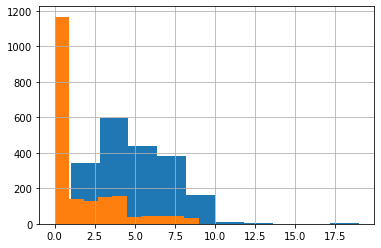

In [3]:
#prepares dataset for histogram creation, removes non-numerical or non-continuous variables
histset = original_df.drop(['CROSS_SELL_SUCCESS',
                            'NAME',
                           'EMAIL',
                           'FIRST_NAME',
                           'FAMILY_NAME',
                            'MOBILE_NUMBER'],
                           axis=1)

#code to view all histograms of variables in the dataframe
#histset.hist( figsize = (10,100), bins=100, grid=False, layout=(23,1))

#histogram for unique meals purchased
histset['UNIQUE_MEALS_PURCH'].hist()

#histogram for early deliveries
histset['EARLY_DELIVERIES'].hist()

<h1> Data Preparation </h1>

<strong>Next I prepared my loaded data for modeling by defining response and explanatory variables and splitting the data into my training and testing sets.</strong>

In [4]:
# preparing explanatory variable data
chef_data   = original_df.drop(['CROSS_SELL_SUCCESS',
                            'NAME',
                           'EMAIL',
                           'FIRST_NAME',
                           'FAMILY_NAME',
                            'MOBILE_NUMBER'],
                           axis=1)

# preparing response variable data
chef_target = original_df.loc[:, 'CROSS_SELL_SUCCESS']

# preparing training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
            chef_data,
            chef_target,
            test_size = 0.25,
            random_state = 222)

<h1> User Defined Functions </h1>

<strong> Here I define my user-defined functions which will later be used for analysis.</strong>

In [5]:
########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = X_train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(pd.np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Tree_Leaf_50_Feature_Importance.png')

<h1> Correlations </h1>

<strong> Correlations reveal the most important variables that affect our response variable, cross sell success. This matrix shows that the percentage of recommendations followed is the most important, with a correlation of 0.46.</strong>

In [6]:
#preparting data for correlation matrix
corr_data   = original_df.drop(['NAME',
                           'EMAIL',
                           'FIRST_NAME',
                           'FAMILY_NAME',
                            'MOBILE_NUMBER'],
                           axis=1)

#defining correlation matrix
df_corr = corr_data.corr().round(2)

#displaying portion of correlation matrix pertaining to our response variable in order to gain insights
df_corr['CROSS_SELL_SUCCESS'].sort_values(ascending = False)

CROSS_SELL_SUCCESS              1.00
FOLLOWED_RECOMMENDATIONS_PCT    0.46
CANCELLATIONS_BEFORE_NOON       0.16
TASTES_AND_PREFERENCES          0.08
REFRIGERATED_LOCKER             0.07
MASTER_CLASSES_ATTENDED         0.04
PACKAGE_LOCKER                  0.04
CONTACTS_W_CUSTOMER_SERVICE     0.04
PC_LOGINS                       0.04
MEDIAN_MEAL_RATING              0.03
AVG_PREP_VID_TIME               0.03
LARGEST_ORDER_SIZE              0.02
EARLY_DELIVERIES                0.02
TOTAL_PHOTOS_VIEWED             0.01
LATE_DELIVERIES                 0.01
TOTAL_MEALS_ORDERED             0.01
AVG_TIME_PER_SITE_VISIT         0.01
UNIQUE_MEALS_PURCH              0.00
REVENUE                         0.00
PRODUCT_CATEGORIES_VIEWED       0.00
WEEKLY_PLAN                    -0.01
AVG_CLICKS_PER_VISIT           -0.04
CANCELLATIONS_AFTER_NOON       -0.05
MOBILE_LOGINS                  -0.05
Name: CROSS_SELL_SUCCESS, dtype: float64

<h1>Logistic Regression </h1>

<strong>Next I instantiated, fit, and predicted my logistic regression model. I saved the auc, test, and train scores for this model for later comparison. </strong>

In [7]:
# INSTANTIATING a model object
logreg = LogisticRegression(solver = 'lbfgs',
                            C = 1,
                            random_state = 222)


# FITTING to the training data
logreg_fit = logreg.fit(X_train, y_train)


# PREDICTING on new data
logreg_pred = logreg_fit.predict(X_test)


# SCORING the results #these print statements are used for checking my code before doing the model comparison below
#print('Training ACCURACY:', logreg_fit.score(X_train, y_train).round(4))
#print('Testing  ACCURACY:', logreg_fit.score(X_test, y_test).round(4))
#print('AUC Score        :', roc_auc_score(y_test,logreg_pred).round(4))

# saving scoring data for future use
lr_train_score = logreg_fit.score(X_train, y_train).round(4)
lr_test_score  = logreg_fit.score(X_test, y_test).round(4)
lr_auc_score = roc_auc_score(y_test,logreg_pred).round(4)

C:\Users\mabra\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


<h1>KNN Classification </h1>

<strong>Next I instantiated, fit, and predicted my KNN classification model. I also saved the auc, test, and train scores for this model for later comparison. </strong>

In [8]:
# INSTANTIATING a KNN classification model with optimal neighbors
knn_opt = KNeighborsClassifier(n_neighbors = 2)


# FITTING the training data
knn_fit = knn_opt.fit(X_train, y_train)


# PREDICTING based on the testing set
knn_pred = knn_fit.predict(X_test)


# SCORING the results #these print statements are used for checking my code before doing the model comparison below
#print('Training ACCURACY:', knn_fit.score(X_train, y_train).round(4))
#print('Testing  ACCURACY:', knn_fit.score(X_test, y_test).round(4))
#print('AUC Score        :', roc_auc_score(y_true  = y_test,
#                                          y_score = knn_pred).round(4))

#saving results for comparison
knn_train_score = knn_fit.score(X_train, y_train).round(4)
knn_test_score = knn_fit.score(X_test, y_test).round(4)
knn_auc_score = roc_auc_score(y_true  = y_test,
                                          y_score = knn_pred).round(4)



<h1> Full Decision Tree </h1>

<strong>Next I instantiated, fit, and predicted my full decision tree model. Again, I saved the auc, test, and train scores for this model for later comparison. </strong>

In [9]:
# INSTANTIATING a classification tree object
full_tree = DecisionTreeClassifier()


# FITTING the training data
full_tree_fit = full_tree.fit(X_train, y_train)


# PREDICTING on new data
full_tree_pred = full_tree_fit.predict(X_test)


# SCORING the model #these print statements are used for checking my code before doing the model comparison below
#print('Training ACCURACY:', full_tree_fit.score(X_train, y_train).round(4))
#print('Testing  ACCURACY:', full_tree_fit.score(X_test, y_test).round(4))
#print('AUC Score        :', roc_auc_score(y_true  = y_test,
#                                          y_score = full_tree_pred).round(4))

#saving results for comparison
full_train_score = full_tree_fit.score(X_train, y_train).round(4)
full_test_score = full_tree_fit.score(X_test, y_test).round(4)
full_auc_score = roc_auc_score(y_true  = y_test,
                                          y_score = full_tree_pred).round(4)

<h1>Pruned Decision Tree</h1>

<strong>Next I instantiated, fit, and predicted my pruned decision tree model. Once again, I saved the auc, test, and train scores for this model for later comparison. </strong>

In [10]:
# INSTANTIATING a classification tree object
tree_pruned      = DecisionTreeClassifier(max_depth = 4,
                                          min_samples_leaf = 25,
                                          random_state = 802)


# FITTING the training data
tree_pruned_fit  = tree_pruned.fit(X_train, y_train)


# PREDICTING on new data
tree_pred = tree_pruned_fit.predict(X_test)


# SCORING the model #these print statements are used for checking my code before doing the model comparison below
#print('Training ACCURACY:', tree_pruned_fit.score(X_train, y_train).round(4))
#print('Testing  ACCURACY:', tree_pruned_fit.score(X_test, y_test).round(4))
#print('AUC Score        :', roc_auc_score(y_true  = y_test,
#                                          y_score = tree_pred).round(4))

#saving results for comparison
pruned_train_score = tree_pruned_fit.score(X_train, y_train).round(4)
pruned_test_score = tree_pruned_fit.score(X_test, y_test).round(4)
pruned_auc_score = roc_auc_score(y_true  = y_test,
                                          y_score = tree_pred).round(4)

<h1>Feature Importance From Trees</h1>

<strong>I plotted the feature importances from my pruned tree to determine the most important variables for predicting cross sell success. I can compare these results with my correlation above to gain insights about this business problem. Both this feature importane chart and my correlation matrix indicate that the percentage of recommendations followed is hte most important determinant of cross sell success. </strong>

C:\Users\mabra\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


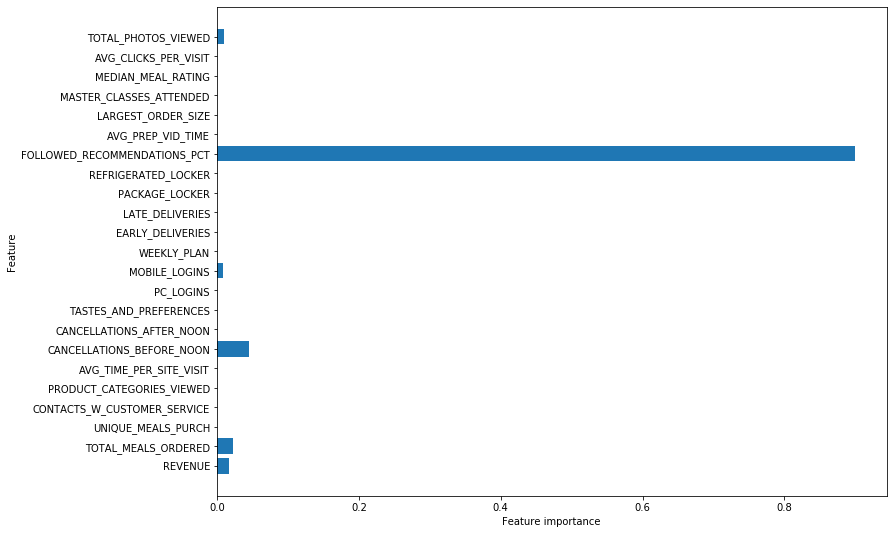

In [11]:
# plotting feature importance
plot_feature_importances(tree_pruned_fit,
                         train = X_train,
                         export = False)

<h1>Catboost Classification</h1>

<strong>Now I tried my CatBoostClassifier model. As always, I saved the auc, test, and train scores for this model for later comparison. </strong>

In [12]:
#function for suppressing unnecessary iteration output
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

# INSTANTIATING a model object with chosen hyperparamaters
cat_model = CatBoostClassifier(learning_rate=.0000003,iterations=4000,depth =5,  l2_leaf_reg=10,thread_count=4,
                             border_count=50, random_strength=.8, grow_policy='Depthwise', min_data_in_leaf=1)

#d=6,7,8
with suppress_stdout():
    # FITTING the training data
    cat_fit = cat_model.fit(X_train, y_train,
                           use_best_model=True,
                          eval_set= (X_test, y_test))


    # PREDICTING on new data
    cat_pred = cat_model.predict(X_test)
    


# saving scoring data for future use
cat_train_score = cat_model.score(X_train, y_train).round(4)
cat_test_score  = cat_model.score(X_test, y_test).round(4)
cat_auc_score = roc_auc_score(y_test,cat_pred).round(4)
test_score = cat_test_score

#printing results to check my code
#print('Training Score:', cat_model.score(X_train, y_train).round(4))
#print('Testing Score:',  cat_model.score(X_test, y_test).round(4))
#print(f"""AUC Score    :{cat_auc_score}""")

<h1>Model Comparison</h1>

<strong>Next I compared the results of these models and selected my final model with which I would move forward. I also saved these results to an excel file.</strong>

In [13]:
# comparing results

print(f"""
Model      Train Score      Test Score      AUC Score
-----      -----------      ----------      ----------
LogReg     {lr_train_score}           {lr_test_score}           {lr_auc_score}
KNN        {knn_train_score}           {knn_test_score}           {knn_auc_score}
FullTree   {full_train_score}              {full_test_score}           {full_auc_score}
PrunedTree {pruned_train_score}           {pruned_test_score}           {pruned_auc_score}
Cat        {cat_train_score}           {cat_test_score}           {cat_auc_score}
""")


# creating a dictionary for model results
model_performance = {'Model'    : ['LogReg', 'KNN', 'FullTree', 'PrunedTree', 'Cat'],
           
                     'Training' : [lr_train_score, knn_train_score,
                                   full_train_score, pruned_train_score, cat_train_score],
           
                     'Testing'  : [lr_test_score, knn_test_score,
                                   full_test_score, pruned_test_score, cat_test_score],

                     'AUC'      : [lr_auc_score, knn_auc_score,
                                   full_auc_score, pruned_auc_score, cat_auc_score]}


# converting model_performance into a DataFrame
model_performance = pd.DataFrame(model_performance)


# sending model results to Excel
model_performance.to_excel('classification_model_performance.xlsx',
                           index = False)


Model      Train Score      Test Score      AUC Score
-----      -----------      ----------      ----------
LogReg     0.6785           0.6448           0.5791
KNN        0.8026           0.5852           0.6078
FullTree   1.0              0.7228           0.684
PrunedTree 0.7827           0.7762           0.7593
Cat        0.8005           0.7803           0.7753



<h1>Conclusion</h1>

<strong>Based on this comparison of model performance, I chose CatboostClassifier as my final model.</strong>                     

<h1>Notes</h1>

<strong>Below I show a number of variables that I created and tested. These variables often helped logistic regression, but did not help KNN or tree models. Therefore, I did not include these variables in my analysis.<strong>

In [14]:
#I tried creating a series of categorical variables to mark turning points in revenue trends for the following variables
#contacts with customer service > 10 marks a turning point in trend
#dataset['CWCSover10'] = [1 if x >10 else 0 for x in dataset['CONTACTS_W_CUSTOMER_SERVICE']]

#clicksover15 marks a turning point in trend
#dataset['Clicksover15'] = [1 if x >15 else 0 for x in dataset['AVG_CLICKS_PER_VISIT']]

#clicksover15 marks a turning point in trend
#dataset['latedeliveriesover13'] = [1 if x >13 else 0 for x in dataset['LATE_DELIVERIES']]

#dummy variable for mobile logins trend threshold
#dataset['mobilecat'] = [1 if x == 1 or x==2 else 0 for x in dataset['MOBILE_LOGINS']]

#dummyvariable for unique meals purchased trend threshold
#dataset['uniquecat'] = [1 if x>9.5 else 0 for x in dataset['UNIQUE_MEALS_PURCH']]

#I tried one hot encoding median meal rating
#dataset = pd.concat([dataset, pd.get_dummies(dataset['MEDIAN_MEAL_RATING'])],axis=1)
#dataset.columns = [                     'REVENUE',           'CROSS_SELL_SUCCESS',
#                               'NAME',                        'EMAIL',
#                         'FIRST_NAME',                  'FAMILY_NAME',
#                'TOTAL_MEALS_ORDERED',           'UNIQUE_MEALS_PURCH',
#        'CONTACTS_W_CUSTOMER_SERVICE',    'PRODUCT_CATEGORIES_VIEWED',
#            'AVG_TIME_PER_SITE_VISIT',                'MOBILE_NUMBER',
#          'CANCELLATIONS_BEFORE_NOON',     'CANCELLATIONS_AFTER_NOON',
#            'TASTES_AND_PREFERENCES',                    'PC_LOGINS',
#                      'MOBILE_LOGINS',                  'WEEKLY_PLAN',
#                   'EARLY_DELIVERIES',              'LATE_DELIVERIES',
#                     'PACKAGE_LOCKER',          'REFRIGERATED_LOCKER',
#       'FOLLOWED_RECOMMENDATIONS_PCT',            'AVG_PREP_VID_TIME',
#                 'LARGEST_ORDER_SIZE',      'MASTER_CLASSES_ATTENDED',
#                 'MEDIAN_MEAL_RATING',         'AVG_CLICKS_PER_VISIT',
#                'TOTAL_PHOTOS_VIEWED',                   'CWCSover10',
#                       'Clicksover15',         'latedeliveriesover13',
#                          'mobilecat',                    'uniquecat',
#                           'rating_1',                     'rating_2',
#                           'rating_3',                     'rating_4',
#                           'rating_5']

#I tried one hot encoding masters classes attended
#dataset = pd.concat([dataset, pd.get_dummies(dataset['MASTER_CLASSES_ATTENDED'])],axis=1)
#dataset.columns = [                     'REVENUE',           'CROSS_SELL_SUCCESS',
#                               'NAME',                        'EMAIL',
#                         'FIRST_NAME',                  'FAMILY_NAME',
#                'TOTAL_MEALS_ORDERED',           'UNIQUE_MEALS_PURCH',
#        'CONTACTS_W_CUSTOMER_SERVICE',    'PRODUCT_CATEGORIES_VIEWED',
#            'AVG_TIME_PER_SITE_VISIT',                'MOBILE_NUMBER',
#          'CANCELLATIONS_BEFORE_NOON',     'CANCELLATIONS_AFTER_NOON',
#             'TASTES_AND_PREFERENCES',                    'PC_LOGINS',
#                      'MOBILE_LOGINS',                  'WEEKLY_PLAN',
#                   'EARLY_DELIVERIES',              'LATE_DELIVERIES',
#                     'PACKAGE_LOCKER',          'REFRIGERATED_LOCKER',
#       'FOLLOWED_RECOMMENDATIONS_PCT',            'AVG_PREP_VID_TIME',
#                 'LARGEST_ORDER_SIZE',      'MASTER_CLASSES_ATTENDED',
#                 'MEDIAN_MEAL_RATING',         'AVG_CLICKS_PER_VISIT',
#                'TOTAL_PHOTOS_VIEWED',                   'CWCSover10',
#                       'Clicksover15',         'latedeliveriesover13',
#                          'mobilecat',                    'uniquecat',
#                           'rating_1',                     'rating_2',
#                           'rating_3',                     'rating_4',
#                           'rating_5',                      'class_0',
#                            'class_1',                      'class_2',
#                            'class_3']

#I tried splitting email into domain addresses and one hot encoding this variable into cateogricals for each domain
#dataset['domain'] = dataset['EMAIL'].str.split('@').str[1]
#dataset = pd.concat([dataset, pd.get_dummies(dataset['domain'])],axis=1)

#this loop creates interaction terms between every explanatory variable
#this helped for linear, lasso, ridge, and ARD but did not help for Cat
#L=[(x, y) for x, y in itertools.product(chef_data.columns,chef_data.columns) if x != y]
#interaction_data = pd.concat([pd.DataFrame({''.join(i):chef_data.loc[:,i].prod(axis=1)}) for i in L],axis=1)
#chef_data = pd.concat([chef_data, interaction_data], axis=1)

<h1>                            .O°o. .o°O________________________________O°o. .o°O.
                            .°o.O.o° ¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯.°o.O.o°
                            ░░░░░╔══╦╗░░░░╔╗░░░░░░╔╗╔╗░░░░░░░░
                            ░░░░░╚╗╔╣╚╦═╦═╣║╔╗░░░░║║║╠═╦╦╗░░░░
                            ░░░░░░║║║║╠╝║║║╠╝║░░░░║╚╝║║║║║░░░░
                            ░░░░░░║║║║║║║║║╔╗╣░░░░╚╗╔╣║║║║░░░░
                            ░░░░░░╚╝╚╩╩═╩╩╩╝╚╝░░░░░╚╝╚═╩═╝░░░░
                            .O°o. .o°O________________________________O°o. .o°O.
                            .°o.O.o° ¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯.°o.O.o°..</h1>